# Captcha predictor

Nikita Babich
ITMO University
@spacexer


# Sources to analyze
- https://habr.com/ru/companies/wunderfund/articles/331310/
- https://habr.com/ru/articles/720614/
- https://neurohive.io/ru/tutorial/primer-vzloma-prostoj-kapchi-za-15-minut-s-pomoshhju-mashinnogo-obuchenija/
- https://habr.com/ru/companies/mvideo/articles/780774/
- https://habr.com/ru/companies/skillfactory/articles/525214/
- https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/
- https://habr.com/ru/articles/464337/
- https://github.com/artempelevin/simple_captcha_solver

In [1]:
import albumentations
import numpy as np
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F

from PIL import Image

import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings

In [2]:
DIR = "dataset"
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 150
DEVICE = "cuda"
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = {
    "paths": paths,
    "labels": labels
}

Идея в том, чтобы на имеющемся наборе картинок с каггла, где в названии лежит ответ на неё (10000 картинок) построить датасет для тренировки и теста, после чего пользоваться моделью для предсказания уже без обновления весов.

# Модель

Использую двухслойную свёрточную нейронку с рекурсией GRU
Для функции потерь использую встроенную CTCLoss

In [4]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [5]:
class Captcha_model(nn.Module):
    """
    Using pytorch nn class to create model

    2 layers CNN
    1 RNN layer
    1 GRU layer

    forward method by template from kaggle

    """
    def __init__(self, num_chars):
        super(Captcha_model, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # LSTM GRU
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)


    def forward(self, images, targets=None):
        bs, channel, height, width = images.size()

        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss

        return x, None

Построю функции для тренировки и вычисления

In [6]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

# Интеграция картинок

Изначальная задумка была в том, чтобы использовать зашумленные линиями капчи, но все фильтры, которые пытался использовать (как в источнике на гите) не работали в сочетании с моделью, поэтому отказался от них - использую просто размытые, разноцветные капчи из букв и цифр

In [7]:
def encode_targets():
    image_files = glob.glob(os.path.join(DIR, "*.jpg"))
    targets_orig = [x.split("\\")[-1].split(".")[0] for x in image_files]
    targets = [[c for c in x] for x in targets_orig]
    targets_flat = [c for clist in targets for c in clist]

    # Encode images
    lbl_enc = LabelEncoder()
    lbl_enc.fit(targets_flat)

    targets_enc = [lbl_enc.transform(x) for x in targets]
    targets_enc = np.array(targets_enc) + 1 # remove 0 index

    return image_files, targets_enc, targets_orig, lbl_enc

In [8]:
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)

Рома подсказал мне, что удобно пользоваться встроенным в торч дата лоадером

In [9]:
class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [10]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False
)

In [11]:
# Load the models
model = Captcha_model(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [12]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop"
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

In [13]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

## Запуск модели с заданными параметрами и функцией ограничения от переобучения

In [14]:
patience = 6
count = 0
prev_train_loss = 0
threshold = 0.05
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)
    
    loss.append(train_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss

100%|██████████| 1000/1000 [00:02<00:00, 447.43it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------------------'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------------------'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------------------------'),
 ('862n6P13Hi',
  '---------------------------------------------------------------------------'),
 ('RsPDymcb49',
  '---------------------------------------------------------------------------')]
Epoch: 0, train_loss: 4.288155458079444, valid_loss: 4.215512638568878


100%|██████████| 1000/1000 [00:02<00:00, 441.50it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------------------'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------------------'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------------------------'),
 ('862n6P13Hi',
  '---------------------------------------------------------------------------'),
 ('RsPDymcb49',
  '---------------------------------------------------------------------------')]
Epoch: 1, train_loss: 4.200148448414272, valid_loss: 4.182215594053268


100%|██████████| 1000/1000 [00:02<00:00, 432.15it/s]


[('9KN1224J1H',
  '------------------------------------------------------------------888881110'),
 ('LxB8Hdx83P',
  '------------------------------------------------------------------888881110'),
 ('bmqnN0sdDX',
  '------------------------------------------------------------------888881110'),
 ('862n6P13Hi',
  '------------------------------------------------------------------888881110'),
 ('RsPDymcb49',
  '------------------------------------------------------------------888881110')]
Epoch: 2, train_loss: 4.181032081312604, valid_loss: 4.162078500747681


100%|██████████| 1000/1000 [00:02<00:00, 430.29it/s]


[('9KN1224J1H',
  '----------------------------------------------------------------8----------'),
 ('LxB8Hdx83P',
  '----------------------------------------------------------------8----------'),
 ('bmqnN0sdDX',
  '----------------------------------------------------------------8----------'),
 ('862n6P13Hi',
  '----------------------------------------------------------------8----------'),
 ('RsPDymcb49',
  '----------------------------------------------------------------8----------')]
Epoch: 3, train_loss: 4.170442198197047, valid_loss: 4.161333736896515


100%|██████████| 1000/1000 [00:02<00:00, 438.40it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------444---------'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------8-----------'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------------8----------4'),
 ('862n6P13Hi',
  '---------------------------------------------------------------66----------'),
 ('RsPDymcb49',
  '---------------------------------------------------------------87---------4')]
Epoch: 4, train_loss: 4.10346818974283, valid_loss: 4.041362189531326


100%|██████████| 1000/1000 [00:02<00:00, 423.19it/s]


[('9KN1224J1H',
  '--------------------------------------------------------------KK----------1'),
 ('LxB8Hdx83P',
  '--------------------------------------------------------------0-----------1'),
 ('bmqnN0sdDX',
  '--------------------------------------------------------------7-----------K'),
 ('862n6P13Hi',
  '--------------------------------------------------------------96----------1'),
 ('RsPDymcb49',
  '--------------------------------------------------------------00----------6')]
Epoch: 5, train_loss: 3.992518363793691, valid_loss: 3.9358055205345153


100%|██████████| 1000/1000 [00:02<00:00, 447.23it/s]


[('9KN1224J1H',
  '----------------------------------------------------------------WM-------31'),
 ('LxB8Hdx83P',
  '----------------------------------------------------------------10----44-31'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------------66---------W'),
 ('862n6P13Hi',
  '----------------------------------------------------------------944-------1'),
 ('RsPDymcb49',
  '----------------------------------------------------------------333------46')]
Epoch: 6, train_loss: 3.9113216444386376, valid_loss: 3.83349551987648


100%|██████████| 1000/1000 [00:02<00:00, 420.88it/s]


[('9KN1224J1H',
  '----------------------------------------------------------------9MMMM--6--7'),
 ('LxB8Hdx83P',
  '----------------------------------------------------------------666----4-77'),
 ('bmqnN0sdDX',
  '----------------------------------------------------------------777--K----W'),
 ('862n6P13Hi',
  '----------------------------------------------------------------944-------1'),
 ('RsPDymcb49',
  '----------------------------------------------------------------10-------40')]
Epoch: 7, train_loss: 3.8338238189485336, valid_loss: 3.794700050354004


100%|██████████| 1000/1000 [00:02<00:00, 445.24it/s]


[('9KN1224J1H',
  '----------------------------------------------------------------4MXX---6-70'),
 ('LxB8Hdx83P',
  '----------------------------------------------------------------666----4-70'),
 ('bmqnN0sdDX',
  '----------------------------------------------------------------700--X----W'),
 ('862n6P13Hi',
  '----------------------------------------------------------------666-66----0'),
 ('RsPDymcb49',
  '----------------------------------------------------------------88000----46')]
Epoch: 8, train_loss: 3.7730852155420513, valid_loss: 3.7238867876529693


100%|██████████| 1000/1000 [00:02<00:00, 360.12it/s]


[('9KN1224J1H',
  '-----------------------------------------------------------------9M66--4777'),
 ('LxB8Hdx83P',
  '-----------------------------------------------------------------84100-4277'),
 ('bmqnN0sdDX',
  '-----------------------------------------------------------------777KK-7--K'),
 ('862n6P13Hi',
  '-----------------------------------------------------------------96666--888'),
 ('RsPDymcb49',
  '-----------------------------------------------------------------888888--40')]
Epoch: 9, train_loss: 3.7251941209369237, valid_loss: 3.710820546865463


100%|██████████| 1000/1000 [00:02<00:00, 373.41it/s]


[('9KN1224J1H',
  '-------------------------------------------------------------9M----------77'),
 ('LxB8Hdx83P',
  '-------------------------------------------------------------34--------4-77'),
 ('bmqnN0sdDX',
  '-------------------------------------------------------------77-----------W'),
 ('862n6P13Hi',
  '-------------------------------------------------------------966----------7'),
 ('RsPDymcb49',
  '-------------------------------------------------------------17----------40')]
Epoch: 10, train_loss: 3.685716678327984, valid_loss: 3.6784327034950257


100%|██████████| 1000/1000 [00:02<00:00, 382.05it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------9KKK-----335'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------343-----4235'),
 ('bmqnN0sdDX',
  '---------------------------------------------------------------777--N-----K'),
 ('862n6P13Hi',
  '---------------------------------------------------------------996--------0'),
 ('RsPDymcb49',
  '---------------------------------------------------------------88000-----40')]
Epoch: 11, train_loss: 3.653072373151779, valid_loss: 3.621197773694992


100%|██████████| 1000/1000 [00:02<00:00, 407.50it/s]


[('9KN1224J1H',
  '----------------------------------------------------------------9KKKK--Y111'),
 ('LxB8Hdx83P',
  '----------------------------------------------------------------3422---4111'),
 ('bmqnN0sdDX',
  '----------------------------------------------------------------772-W-7---K'),
 ('862n6P13Hi',
  '----------------------------------------------------------------96696-----1'),
 ('RsPDymcb49',
  '----------------------------------------------------------------8882-----40')]
Epoch: 12, train_loss: 3.6153435989750755, valid_loss: 3.5723772256374358


100%|██████████| 1000/1000 [00:02<00:00, 431.22it/s]


[('9KN1224J1H',
  '-----------------------------------------------------------------9KK6--4222'),
 ('LxB8Hdx83P',
  '----------------------------------------------------------------2k222--k122'),
 ('bmqnN0sdDX',
  '-----------------------------------------------------------------722XX----K'),
 ('862n6P13Hi',
  '----------------------------------------------------------------966666----2'),
 ('RsPDymcb49',
  '----------------------------------------------------------------22222----40')]
Epoch: 13, train_loss: 3.6029924680921765, valid_loss: 3.552323966503143


100%|██████████| 1000/1000 [00:02<00:00, 425.92it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------9XKX---4---5'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------3x5--------5'),
 ('bmqnN0sdDX',
  '------------------------------------------------------------555--W--------K'),
 ('862n6P13Hi',
  '---------------------------------------------------------------966--6-----1'),
 ('RsPDymcb49',
  '---------------------------------------------------------------85005----440')]
Epoch: 14, train_loss: 3.574404195653068, valid_loss: 3.540178488254547


100%|██████████| 1000/1000 [00:02<00:00, 414.42it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------9KKM---4-558'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------3k22-----811'),
 ('bmqnN0sdDX',
  '--------------------------------------------------------------7772-A------X'),
 ('862n6P13Hi',
  '---------------------------------------------------------------966--6-----1'),
 ('RsPDymcb49',
  '---------------------------------------------------------------1100-2---446')]
Epoch: 15, train_loss: 3.5364498528374564, valid_loss: 3.4817765564918517


100%|██████████| 1000/1000 [00:02<00:00, 381.97it/s]


[('9KN1224J1H',
  '---------------------------------------------------------------9MMM6--44511'),
 ('LxB8Hdx83P',
  '---------------------------------------------------------------3k388----211'),
 ('bmqnN0sdDX',
  '------------------------------------------------------------7700-N--------X'),
 ('862n6P13Hi',
  '---------------------------------------------------------------966-6------1'),
 ('RsPDymcb49',
  '---------------------------------------------------------------110008---446')]
Epoch: 16, train_loss: 3.4936480956077576, valid_loss: 3.4366307482719423


100%|██████████| 1000/1000 [00:02<00:00, 341.41it/s]


[('9KN1224J1H',
  '------------9-------X-------N-----------------------44--------------------1'),
 ('LxB8Hdx83P',
  '-------------------k----------------------------------k-------------------0'),
 ('bmqnN0sdDX',
  '-----------------------------------------N--------------------------------X'),
 ('862n6P13Hi',
  '-------------------6--------------------66--------------------------------1'),
 ('RsPDymcb49',
  '-----------------------------------------y------------------------4-------0')]
Epoch: 17, train_loss: 3.333817799170812, valid_loss: 2.9010731568336485


100%|██████████| 1000/1000 [00:02<00:00, 429.00it/s]


[('9KN1224J1H',
  '-----------9--------K-----NN-----1----5-----5-------4------1-------1------1'),
 ('LxB8Hdx83P',
  '------------1----xx-----u-------8-----1-------d-----k-----8-----7---------n'),
 ('bmqnN0sdDX',
  '------------0-----m------d-------n-----N------0----s-------d-------0------X'),
 ('862n6P13Hi',
  '-----------8-----66------7-----h-------6------m-------1---7------1--------1'),
 ('RsPDymcb49',
  '------------S-----s-----m--------0----y-------n-----5-----0-----44--------0')]
Epoch: 18, train_loss: 2.2840584854582944, valid_loss: 1.5250401932001114


100%|██████████| 1000/1000 [00:02<00:00, 423.37it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------1-------1------H'),
 ('LxB8Hdx83P',
  '------------F----x------B-------8-----H-------d----X------8-----3---------2'),
 ('bmqnN0sdDX',
  '------------b-----m------d-------n----N-------0----s-------d-------D------X'),
 ('862n6P13Hi',
  '-----------8-----6-------5-----n-------6------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------n-----C-----b-----4---------y')]
Epoch: 19, train_loss: 1.2356904581967327, valid_loss: 0.7276295284628869


100%|██████████| 1000/1000 [00:02<00:00, 405.84it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------1-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8----HH-------d----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d------DD------X'),
 ('862n6P13Hi',
  '-----------8-----6-------5-----n-------6------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------m-----c-----p-----4---------9')]
Epoch: 20, train_loss: 0.6077561959570481, valid_loss: 0.3355350906401873


100%|██████████| 1000/1000 [00:02<00:00, 425.35it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L-----x-----B-------8-----H-------d-----x-----8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d-------D------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6-------P-----1----3------H--------l'),
 ('RsPDymcb49',
  '------------R------s----P--------D----y-------m-----c-----b-----4---------9')]
Epoch: 21, train_loss: 0.3438406840666301, valid_loss: 0.16300614780560135


100%|██████████| 1000/1000 [00:02<00:00, 429.09it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d-------D------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6------P------1----3------H--------l'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------m-----c-----b-----4---------9')]
Epoch: 22, train_loss: 0.20451383039753676, valid_loss: 0.11953980763303115


100%|██████████| 1000/1000 [00:02<00:00, 410.34it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8----HH-------d----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d-------D------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------m-----c-----b-----4---------9')]
Epoch: 23, train_loss: 0.14091515471884566, valid_loss: 0.06882171080773697


100%|██████████| 1000/1000 [00:02<00:00, 431.22it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L-----x-----B-------8----HH-------d-----x-----8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d-------D------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6-------------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------m-----c-----b-----4---------9')]
Epoch: 24, train_loss: 0.10711343428715028, valid_loss: 0.07832664327265229
Patience at 5


100%|██████████| 1000/1000 [00:02<00:00, 411.70it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8----HH-------d----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d-------D------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------m-----c-----b-----4---------9')]
Epoch: 25, train_loss: 0.09130000660718522, valid_loss: 0.04077769864758011
Patience at 4


100%|██████████| 1000/1000 [00:02<00:00, 431.59it/s]


[('9KN1224J1H',
  '-----------9-------KK-----N------1----2-----2-------4------J------1-------H'),
 ('LxB8Hdx83P',
  '-----------L-----x-----BB-------8----H-------d-----X------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d------D-------X'),
 ('862n6P13Hi',
  '----------8------6-------2-----n-------6------P------1----3-----H---------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y-------mm-----c-----b-----4---------9')]
Epoch: 26, train_loss: 0.07562439205963165, valid_loss: 0.04595634844334563


100%|██████████| 1000/1000 [00:02<00:00, 422.65it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----5-------d------DD------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------m-----c-----b-----4---------9')]
Epoch: 27, train_loss: 0.06601698917089056, valid_loss: 0.06179156841302756
Patience at 3


100%|██████████| 1000/1000 [00:02<00:00, 444.07it/s]


[('9KN1224J1H',
  '-----------9-------KK-----N------1----2-----2-------4------J------1-------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8----H--------d----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d------D-------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------m-----c-----b-----4---------9')]
Epoch: 28, train_loss: 0.059457550476861395, valid_loss: 0.029394316074904055
Patience at 2


100%|██████████| 1000/1000 [00:02<00:00, 419.82it/s]


[('9KN1224J1H',
  '-----------9-------KK-----N------1----2-----2-------4------J------11------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8----H--------d----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d------D-------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6------P------1----3-----HH--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y-------mm-----c-----b-----4---------9')]
Epoch: 29, train_loss: 0.052557982796182234, valid_loss: 0.026991527467325794
Patience at 1


100%|██████████| 1000/1000 [00:02<00:00, 439.37it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8----H--------d----x------8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0---s--------d-------D------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6------P------1----3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s-----P--------D---y--------m-----c-----b-----4---------9')]
Epoch: 30, train_loss: 0.0467203371498779, valid_loss: 0.057150345355214086
Patience at 0


100%|██████████| 1000/1000 [00:02<00:00, 442.09it/s]


[('9KN1224J1H',
  '-----------9--------K-----N------1----2-----2-------4------J-------1------H'),
 ('LxB8Hdx83P',
  '------------L----x------B-------8-----H-------d-----x-----8-----3---------P'),
 ('bmqnN0sdDX',
  '------------b-----m------q-------n----N-------0----s-------d-------D------X'),
 ('862n6P13Hi',
  '-----------8-----6-------2-----n-------6-------P------1---3------H--------i'),
 ('RsPDymcb49',
  '------------R-----s------P-------D----y-------m-----c-----b-----4---------9')]
Epoch: 31, train_loss: 0.04760536588850664, valid_loss: 0.02374061456833442
Early Stopping Implemented.


In [15]:
torch.save(model.state_dict(), "model_finish")

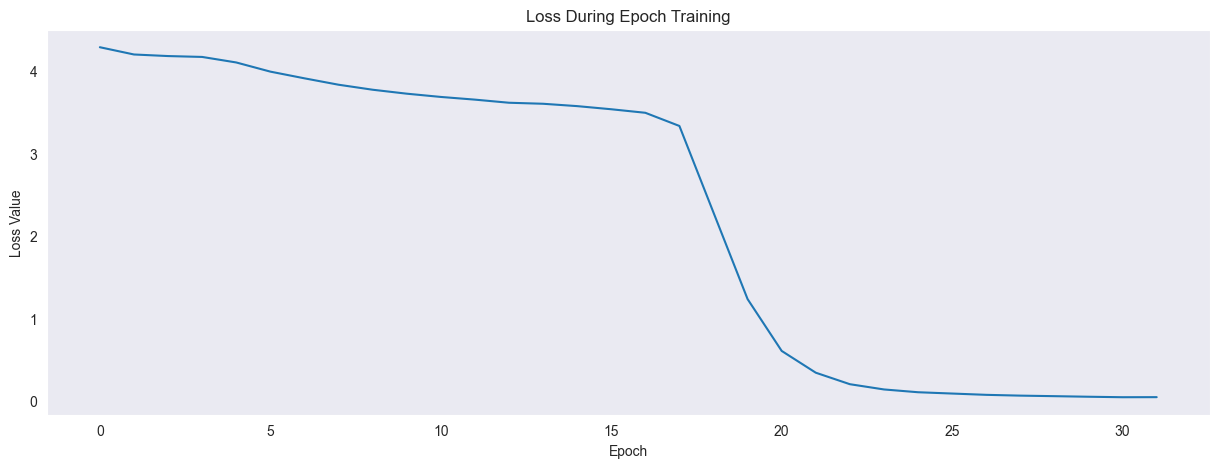

In [37]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
plt.plot(loss)
plt.show()

# Оценка предсказаний нейросети

Проверяю, насколько точно предсказание получается на рандомном изображении

In [34]:
def get_image(image_path=None):
    if image_path == None:
        img = random.choice(df["paths"])
        return [img]
    return [image_path]


def get_sample_photo(image_path=None):
    img = get_image(image_path)
    eval_dataset = DatasetClassifier(
        image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
    )

    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        shuffle=False
    )
    
    return img, eval_loader

In [35]:
image_path, eval_loader = get_sample_photo()
# TODO: parametrize number of chars
def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
    cleaned_predictions = "".join(cleaned_predictions)
    if len(cleaned_predictions) == 10:
        return cleaned_predictions
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("\\")[-1].split(".")[0]
    plt.title(image_path[0].split("\\")[-1])
    plt.imshow(image)
    
    valid_preds, _ = eval_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])

    if preds == target:
        success = True
    else:
        success = False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

100%|██████████| 1/1 [00:00<00:00, 250.03it/s]

{'success': True, 'prediction': 'ZIMBgR3dG3', 'real': 'ZIMBgR3dG3'}


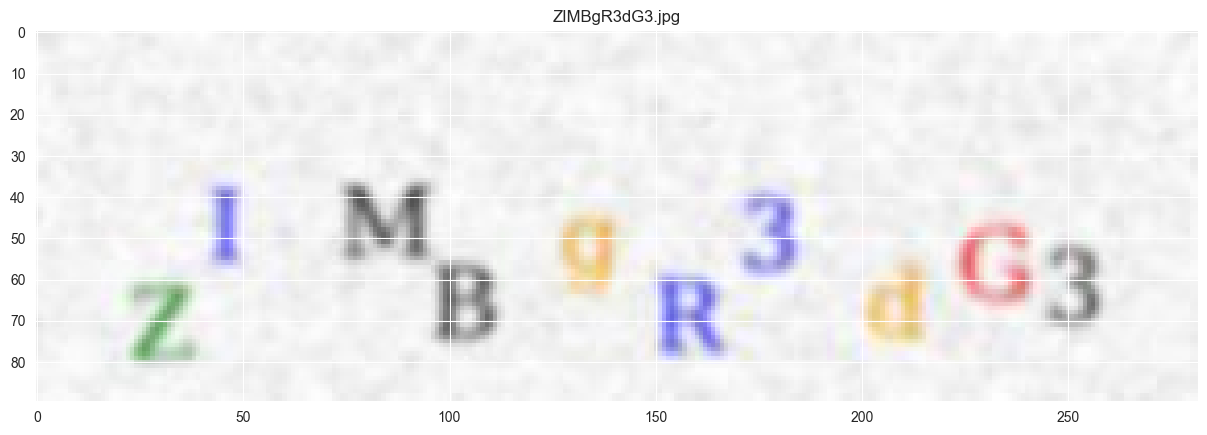

In [36]:
preds = predict_captcha(model, eval_loader, image_path)
print(preds)